# Fit a RL model on individual data

In [1]:
from rlssm.utility.load_data import load_example_dataset
from rlssm.model.models_RL import RLModel_2A

import pandas as pd

## Import individual data

In [2]:
# import some example data:
data = load_example_dataset(hierarchical_levels = 1)

data.head()

,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy
0,15,1,1,50,28,3,1,1,2.630658,1
1,15,1,2,52,44,3,1,2,2.718299,1
2,15,1,3,30,38,2,1,2,2.382882,1
3,15,1,4,64,45,4,2,1,2.167205,1
4,15,1,5,48,26,3,1,3,2.748257,0


## Initialize the model

In [3]:
# you can "turn on and off" different mechanisms:
model = RLModel_2A(hierarchical_levels = 1,
                   increasing_sensitivity = False,
                   separate_learning_rates = True)

15:10:57 - cmdstanpy - INFO - compiling stan file /home/andrei/PycharmProjects/rlssm/rlssm/stan_models/RL_2A/RL_2A_2lr.stan to exe file /home/andrei/PycharmProjects/rlssm/rlssm/stan_models/RL_2A/RL_2A_2lr
15:11:05 - cmdstanpy - INFO - compiled model executable: /home/andrei/PycharmProjects/rlssm/rlssm/stan_models/RL_2A/RL_2A_2lr
15:11:05 - cmdstanpy - WARNING - Stan compiler has produced 6 warnings:
15:11:05 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/andrei/PycharmProjects/rlssm/rlssm/stan_models/RL_2A/RL_2A_2lr.hpp /home/andrei/PycharmProjects/rlssm/rlssm/stan_models/RL_2A/RL_2A_2lr.stan
Warning in '/home/andrei/PycharmProjects/rlssm/rlssm/stan_models/RL_2A/RL_2A_2lr.stan', line 4, column 1: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warni

In [4]:
model.priors

{'sensitivity_priors': {'mu': 1, 'sd': 50},
 'alpha_pos_priors': {'mu': 0, 'sd': 1},
 'alpha_neg_priors': {'mu': 0, 'sd': 1}}

## Fit

In [5]:
# sampling parameters
n_warmup = 500
n_sampling = 2000
n_chains = 2
n_thin = 1

# learning parameters
K = 4 # n options in a learning block (participants see 2 at a time)
initial_value_learning = 27.5 # initial learning value (Q0)

In [6]:
model_fit = model.fit(
    data, 
    K, 
    initial_value_learning,
    sensitivity_priors={'mu': 0, 'sd': 5},
    thin = n_thin,
    iter_warmup=n_warmup,
    iter_sampling=n_sampling,
    chains = n_chains)

15:11:05 - cmdstanpy - INFO - CmdStan start processing


Fitting the model using the priors:
sensitivity_priors {'mu': 0, 'sd': 5}
alpha_pos_priors {'mu': 0, 'sd': 1}
alpha_neg_priors {'mu': 0, 'sd': 1}


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:11:06 - cmdstanpy - INFO - CmdStan done processing.
15:11:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: bernoulli_lpmf: Probability parameter[1] is -nan, but must be in the interval [0, 1] (in '/home/andrei/PycharmProjects/rlssm/rlssm/stan_models/RL_2A/RL_2A_2lr.stan', line 72, column 1 to column 36)
Consider re-running with show_console=True if the above output is unclear!



Checks MCMC diagnostics:
n_eff / iter looks reasonable for all parameters
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 4000 iterations ended with a divergence (0.0%)


## get Rhat

In [7]:
model_fit.rhat

,rhat,variable
name,,
lp__,1.000020,lp__
alpha_pos,0.999835,alpha_pos
alpha_neg,1.000770,alpha_neg
sensitivity,0.999913,sensitivity
log_p_t[1],NaN,log_p_t[1]
...,...,...
log_lik[235],0.999834,log_lik[235]
log_lik[236],0.999857,log_lik[236]
log_lik[237],0.999838,log_lik[237]


## get wAIC

In [8]:
model_fit.waic

{'lppd': -75.48875619791505,
 'p_waic': 2.60430602430708,
 'waic': 156.18612444444426,
 'waic_se': 17.113938998620164}

## Posteriors

In [9]:
model_fit.samples.describe()

,transf_alpha_pos,transf_alpha_neg,transf_sensitivity
count,4000.000000,4000.000000,4000.000000
mean,0.133288,0.358379,0.362473
std,0.047736,0.134856,0.058300
min,0.014110,0.054714,0.212198
25%,0.100332,0.260266,0.322085
50%,0.126734,0.345488,0.357639
75%,0.157665,0.442098,0.395848
max,0.490280,0.924686,0.866057


In [10]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

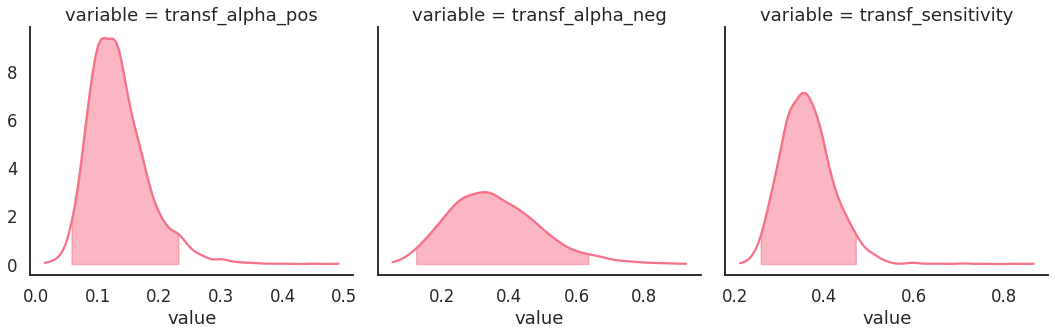

In [11]:
model_fit.plot_posteriors(height=5, show_intervals="HDI", alpha_intervals=.05);

## Posterior predictives

### Ungrouped

In [12]:
pp = model_fit.get_posterior_predictives_df(n_posterior_predictives=1000)
pp

variable accuracy                                      ...                  \
trial         1   2   3   4   5   6   7   8   9   10   ... 230 231 232 233   
sample                                                 ...                   
1               0   1   0   1   0   0   0   0   1   1  ...   1   0   1   0   
2               1   1   0   0   1   1   1   1   1   1  ...   1   1   1   1   
3               1   0   1   1   1   0   1   0   1   1  ...   1   1   1   0   
4               1   1   1   0   1   0   1   0   1   1  ...   1   1   1   0   
5               0   1   1   1   1   0   1   1   1   1  ...   0   0   1   0   
...           ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
996             0   1   1   1   0   0   1   1   1   1  ...   0   1   1   1   
997             1   1   0   0   0   0   0   0   1   1  ...   0   1   1   1   
998             0   1   0   1   0   0   0   1   1   1  ...   1   0   1   1   
999             1   1   0   1   1   1   1   0   1   1  ...   1   1   1   1   
1000            0   1   0   1   1   0   0   1   1   1  ...   1   1   1   1   

variable                          
trial    234 235 236 237 238 239  
sample                            
1          1   1   1   1   1   1  
2          1   1   1   1   1   1  
3          1   1   1   1   1   1  
4          1   1   0   1   1   1  
5          1   1   1   1   1   1  
...       ..  ..  ..  ..  ..  ..  
996        1   1   0   1   1   1  
997        1   1   1   0   1   1  
998        1   1   1   1   1   1  
999        1   1   1   1   1   1  
1000       1   1   1   1   1   1  

[1000 rows x 239 columns]

In [13]:
pp_summary = model_fit.get_posterior_predictives_summary(n_posterior_predictives=1000)
pp_summary

,mean_accuracy
sample,
1,0.853556
2,0.866109
3,0.807531
4,0.857741
5,0.832636
...,...
996,0.815900
997,0.845188
998,0.891213


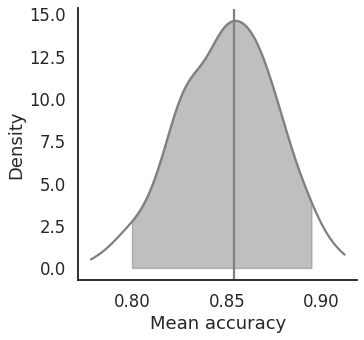

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

model_fit.plot_mean_posterior_predictives(n_posterior_predictives=500, ax=ax, show_intervals='HDI')

ax.set_ylabel('Density')
ax.set_xlabel('Mean accuracy')

sns.despine()

### Grouped

In [15]:
import numpy as np

In [16]:
# Define new grouping variables, in this case, for the different choice pairs, but any grouping var can do
data['choice_pair'] = 'AB'
data.loc[(data.cor_option == 3) & (data.inc_option == 1), 'choice_pair'] = 'AC'
data.loc[(data.cor_option == 4) & (data.inc_option == 2), 'choice_pair'] = 'BD'
data.loc[(data.cor_option == 4) & (data.inc_option == 3), 'choice_pair'] = 'CD'

data['block_bins'] = pd.cut(data.trial_block, 8, labels=np.arange(1, 9))

In [17]:
model_fit.get_grouped_posterior_predictives_summary(grouping_vars=['block_label', 'block_bins', 'choice_pair'], 
                                                    n_posterior_predictives=500)

mean_accuracy
block_label block_bins choice_pair sample               
1           1          AB          1                0.50
                                   2                0.50
                                   3                0.00
                                   4                1.00
                                   5                0.50
...                                                  ...
3           8          CD          496              0.75
                                   497              0.75
                                   498              0.75
                                   499              0.75
                                   500              0.75

[46000 rows x 1 columns]

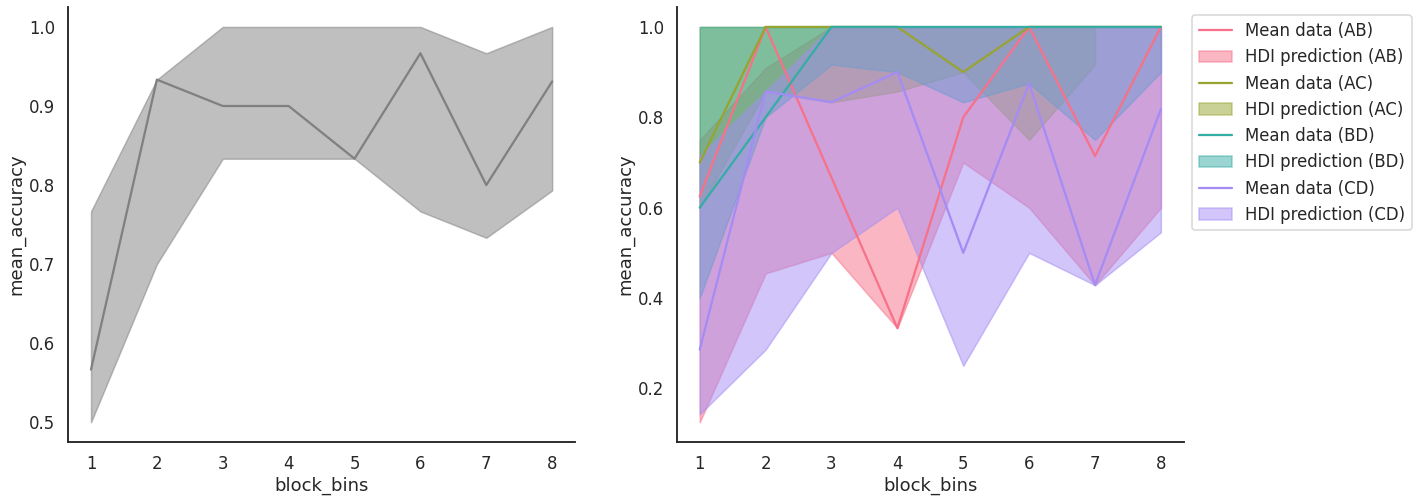

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20,8))

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins'], n_posterior_predictives=500, ax=axes[0])

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins', 'choice_pair'], n_posterior_predictives=500, ax=axes[1])

sns.despine()